In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from pathlib import Path

import motorlab as ml
import numpy as np
import yaml

In [ ]:
os.chdir(Path().resolve().parent)

### pcs to exclude

In [9]:
# obtained in the notebook 'analysis_pca.ipynb'

# delete pcs that are >= 0.15 above baseline.
with open("artifacts/tables/analysis_pca/loose.yml", "r") as f:
    loose = yaml.safe_load(f)

# delete pcs that are >= 0.10 above baseline.
with open("artifacts/tables/analysis_pca/medium.yml", "r") as f:
    medium = yaml.safe_load(f)

# delete pcs that are >= 0.05 above baseline.
with open("artifacts/tables/analysis_pca/strict.yml", "r") as f:
    strict = yaml.safe_load(f)

# delete pcs that are >= 0.01 above baseline.
with open("artifacts/tables/analysis_pca/draconian.yml", "r") as f:
    draconian = yaml.safe_load(f)

### train

In [61]:
experiment = "gbyk"
sessions = ml.sessions.GBYK[:1]
config = ml.config.load_default(experiment, sessions)

config["training"]["n_epochs"] = 5
# config["training"]["n_epochs"] = 30
config["training"]["scheduler"] = "cosine_annealing"
config["training"]["lr"] = 5e-3
config["training"]["eta_min"] = 1e-4

config["uid"] = 20250806043905
config["load_epoch"] = 25

config["model"]["representation"] = "egocentric"
config["model"]["n_layers"] = 5
# config["poses"]["project_to_pca"] = True
# config["poses"]["pcs_to_exclude"] = draconian

ml.model.train(config)

Number of parameters: 345,858
FCModel(
  (embedding): LinearEmbedding(
    (linear): ModuleDict(
      (bex_20230621_spikes_sorted_SES): ModuleDict(
        (poses): Linear(in_features=63, out_features=256, bias=True)
      )
    )
  )
  (core): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
  )
  (readout): Readout(
    (readouts): ModuleDict(
      (bex_20230621_spikes_sorted_SES): ModuleDict(
        (position): Linear(in_features=256, out_features=2, bias=True)
      )
    )
  )
)
uid: 20250806043932
epoch: 0001 | mse: 0.4945
epoch: 0001 | grad_norm: 0.91218889 | loss: 0.2748 | mse: 0.2776
epoch: 0002 | grad_norm: 1.56622314 | loss: 0.2730 | mse: 0.2709
epoch: 0003 | grad_norm: 2.98805881 | loss: 0.2988 | mse: 0.2955
epoch: 0004 | grad_norm: 1.88522959 | loss: 0.2676 | mse: 0.2658
epoch: 0005 | grad_norm: 1.39888680 | loss: 0.2448 | mse: 0.2457


### eval

In [5]:
runs = {
    "allocentric": 20250729190213,
    "centered": 20250729191545,
    "egocentric": 20250729184533,
    "trunk": 20250729193028,
    "head": 20250729195943,
    "pc": 20250729153306,
    "loose": 20250729175541,
    "medium": 20250729180746,
    "strict": 20250729181925,
    "draconian": 20250729183336,
}

In [9]:
config_path = Path(f"config/poses_to_position/{runs['draconian']}.yaml")

with open(config_path, "r") as f:
    config = yaml.safe_load(f)


# config["include_trial"] = True
# config["include_homing"] = False

# config["include_trial"] = False
# config["include_homing"] = True

eval_metrics, eval_gts, eval_preds = ml.model.evaluate(config)

eval_gts = {
    session: gt["position"].reshape(-1, 2) for session, gt in eval_gts.items()
}
tiled_gts = {
    session: ml.room.get_tiles(gt[:, 0], gt[:, 1])
    for session, gt in eval_gts.items()
}

eval_preds = {
    session: pred["position"].reshape(-1, 2)
    for session, pred in eval_preds.items()
}
tiled_preds = {
    session: ml.room.get_tiles(pred[:, 0], pred[:, 1])
    for session, pred in eval_preds.items()
}

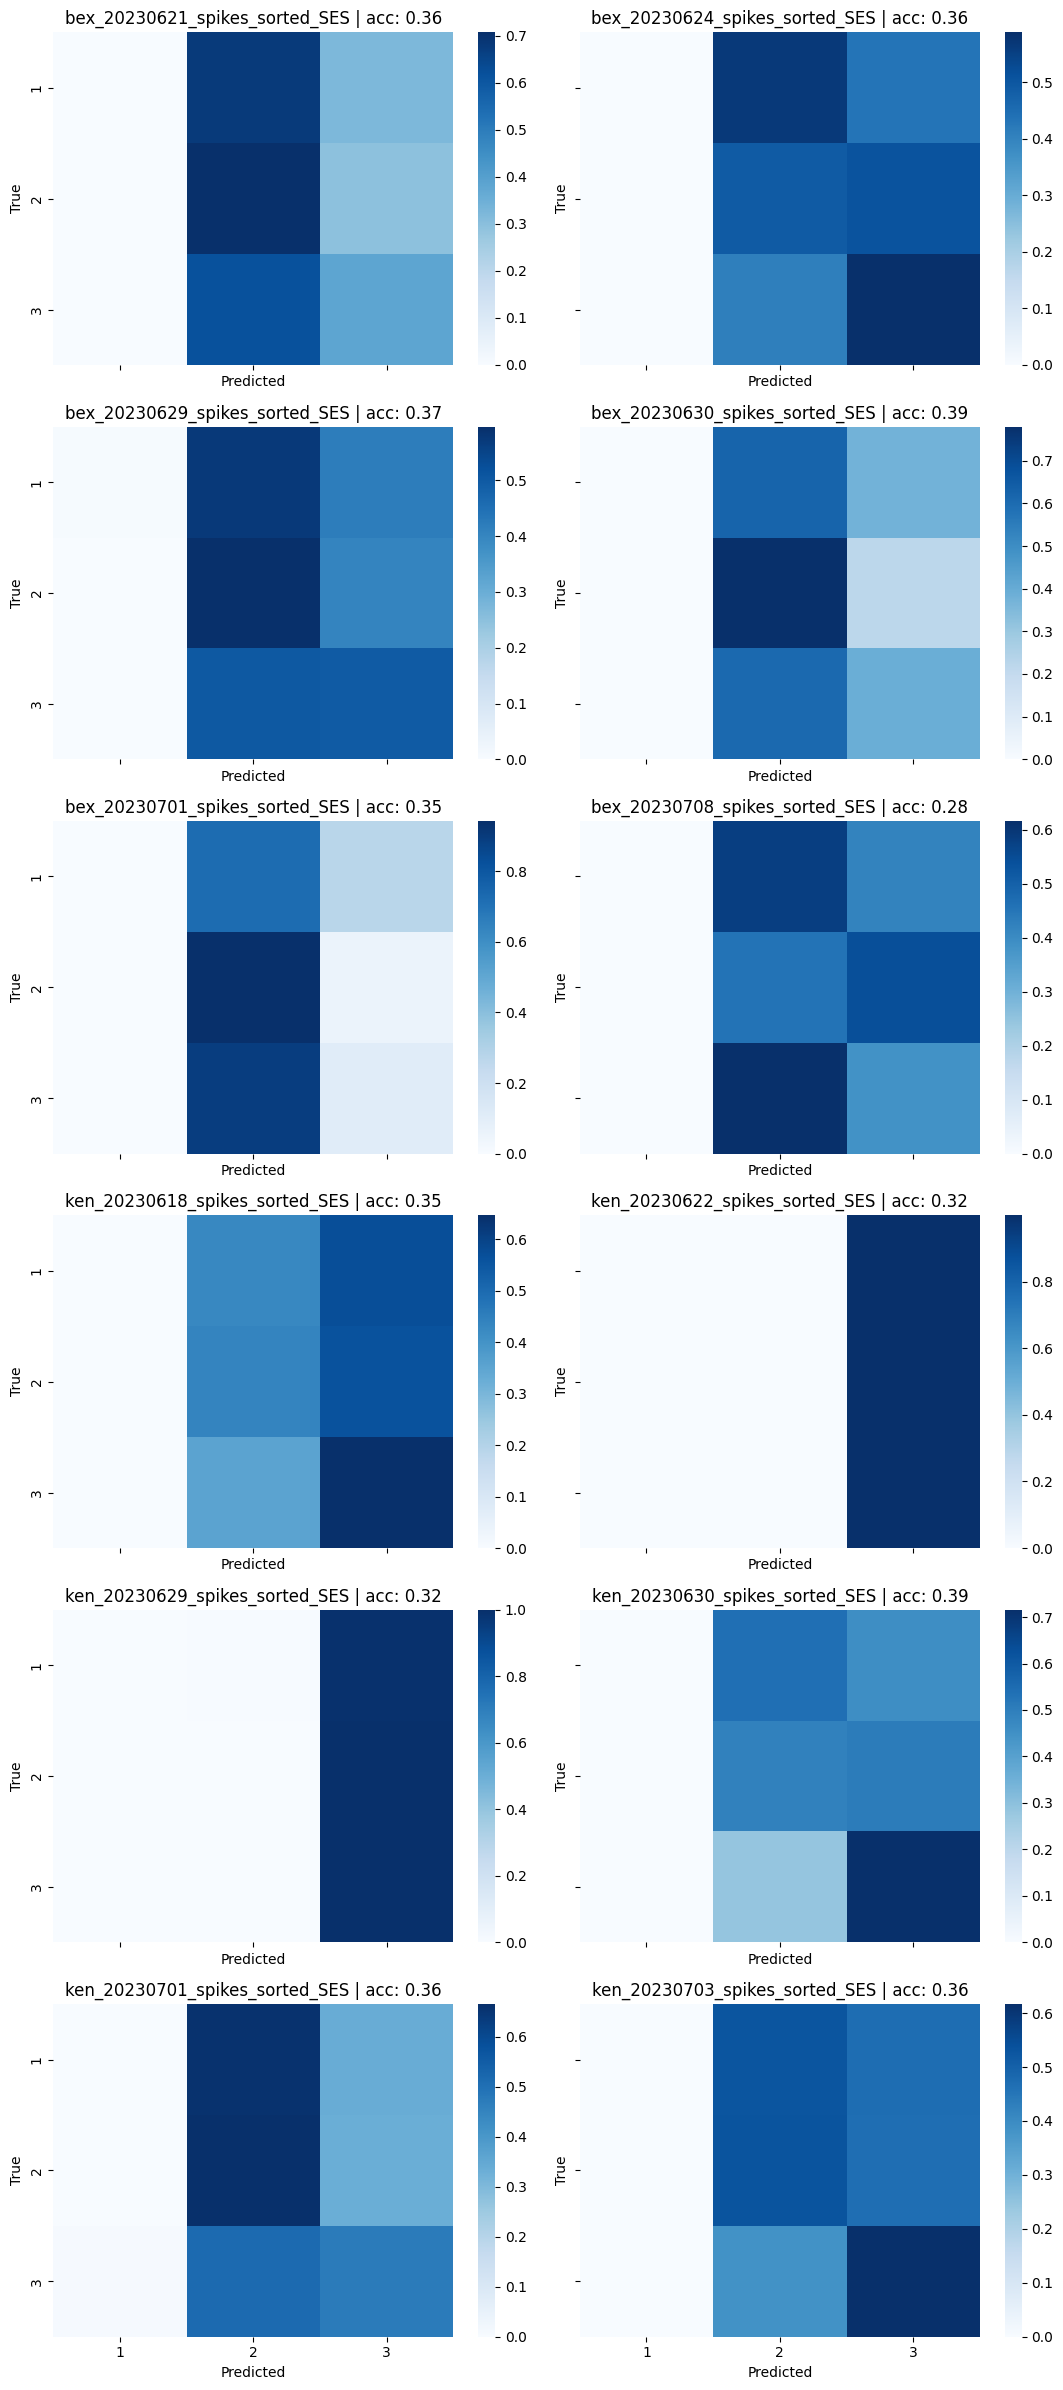

In [10]:
ml.plot.confusion_matrix(
    tiled_gts,
    tiled_preds,
    group="y",
    include_sitting=False,
    # concat=True,
)

In [ ]:
bex_gts = {
    session: gts for session, gts in eval_gts.items() if "bex" in session
}

bex_preds = {
    session: preds for session, preds in eval_preds.items() if "bex" in session
}

ml.plot.room_histogram2d(bex_gts, bex_preds, concat=True)

In [ ]:
bex_tiled_gts = {
    session: gt for session, gt in tiled_gts.items() if "bex" in session
}

bex_tiled_preds = {
    session: pred for session, pred in tiled_preds.items() if "bex" in session
}

ml.plot.confusion_matrix(
    bex_tiled_gts,
    bex_tiled_preds,
    group="y",
    include_sitting=False,
    concat=True,
)

In [ ]:
ken_gts = {
    session: gts for session, gts in eval_gts.items() if "ken" in session
}

ken_preds = {
    session: preds for session, preds in eval_preds.items() if "ken" in session
}

ml.plot.room_histogram2d(ken_gts, ken_preds, concat=True)

In [ ]:
ken_tiled_gts = {
    session: gt for session, gt in tiled_gts.items() if "ken" in session
}

ken_tiled_preds = {
    session: pred for session, pred in tiled_preds.items() if "ken" in session
}

ml.plot.confusion_matrix(
    ken_tiled_gts,
    ken_tiled_preds,
    group="y",
    include_sitting=False,
    concat=True,
)

In [ ]:
bex_ken_gts = {
    "bex": np.concatenate(list(bex_gts.values()), axis=0),
    "ken": np.concatenate(list(ken_gts.values()), axis=0),
}

bex_ken_preds = {
    "bex": np.concatenate(list(bex_preds.values()), axis=0),
    "ken": np.concatenate(list(ken_preds.values()), axis=0),
}

ml.plot.room_histogram2d(
    bex_ken_gts,
    bex_ken_preds,
    # save_path="plots/pose_to_position/histogram_trial_fc.svg",
)

In [ ]:
bex_ken_tiled_gts = {
    "bex": np.concatenate(list(bex_tiled_gts.values()), axis=0),
    "ken": np.concatenate(list(ken_tiled_gts.values()), axis=0),
}

bex_ken_tiled_preds = {
    "bex": np.concatenate(list(bex_tiled_preds.values()), axis=0),
    "ken": np.concatenate(list(ken_tiled_preds.values()), axis=0),
}

ml.plot.confusion_matrix(
    bex_ken_tiled_gts,
    bex_ken_tiled_preds,
    group="y",
    # include_sitting=True,
)

In [ ]:
tile_size = 0.865

gts = {
    "ideal": np.array(
        [
            [1 * tile_size, 0 * tile_size + tile_size / 2],
            [2 * tile_size, 0 * tile_size + tile_size / 2],
            [3 * tile_size, 0 * tile_size + tile_size / 2],
            [1 * tile_size, 1 * tile_size + tile_size / 2],
            [2 * tile_size, 1 * tile_size + tile_size / 2],
            [3 * tile_size, 1 * tile_size + tile_size / 2],
            [1 * tile_size, 2 * tile_size + tile_size / 2],
            [2 * tile_size, 2 * tile_size + tile_size / 2],
            [3 * tile_size, 2 * tile_size + tile_size / 2],
            [1 * tile_size, 3 * tile_size + tile_size / 2],
            [2 * tile_size, 3 * tile_size + tile_size / 2],
            [3 * tile_size, 3 * tile_size + tile_size / 2],
            [1 * tile_size, 4 * tile_size + tile_size / 2],
            [2 * tile_size, 4 * tile_size + tile_size / 2],
            [3 * tile_size, 4 * tile_size + tile_size / 2],
        ]
    )
}
preds = {
    "ideal": np.array(
        [
            [3 * tile_size, 0 * tile_size + tile_size / 2],
            [2 * tile_size, 0 * tile_size + tile_size / 2],
            [1 * tile_size, 0 * tile_size + tile_size / 2],
            [3 * tile_size, 3 * tile_size + tile_size / 2],
            [2 * tile_size, 3 * tile_size + tile_size / 2],
            [1 * tile_size, 3 * tile_size + tile_size / 2],
            [3 * tile_size, 2 * tile_size + tile_size / 2],
            [2 * tile_size, 2 * tile_size + tile_size / 2],
            [1 * tile_size, 2 * tile_size + tile_size / 2],
            [3 * tile_size, 1 * tile_size + tile_size / 2],
            [2 * tile_size, 1 * tile_size + tile_size / 2],
            [1 * tile_size, 1 * tile_size + tile_size / 2],
            [3 * tile_size, 4 * tile_size + tile_size / 2],
            [2 * tile_size, 4 * tile_size + tile_size / 2],
            [1 * tile_size, 4 * tile_size + tile_size / 2],
        ]
    )
}
ml.plot.room_histogram2d(
    gts,
    preds,
    save_path="plots/pose_to_position/histogram_homing_ideal.svg",
)

In [ ]:
ml.plot.confusion_matrix(
    eval_gts,
    eval_preds,
    # group="x",
    include_sitting=True,
    # save_path="plots/pose_to_position/confusion_matrix_nofilter_homing.svg",
)

In [ ]:
ml.room.plot(save_path="plots/pose_to_position/room.svg")